### Main file for calibration ###

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
from Calibration import Calib_position

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


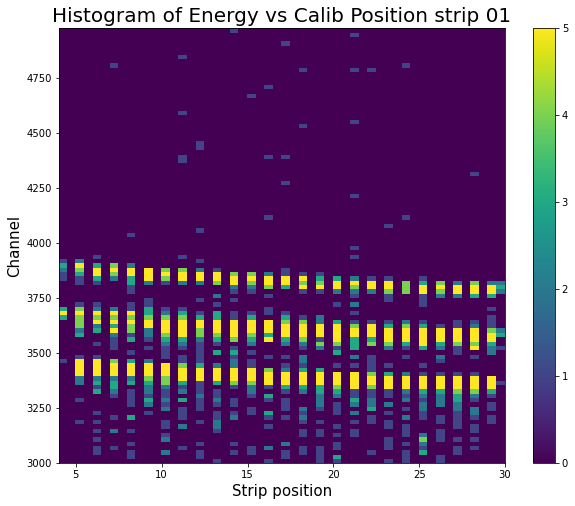

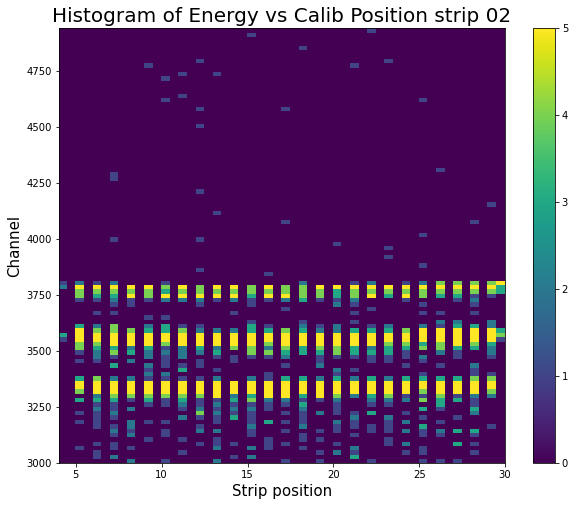

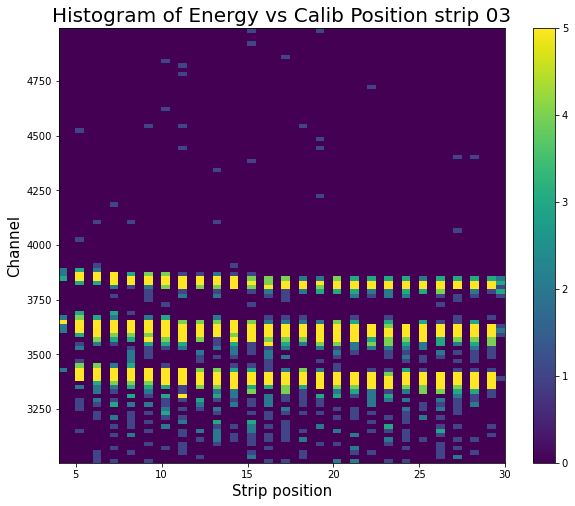

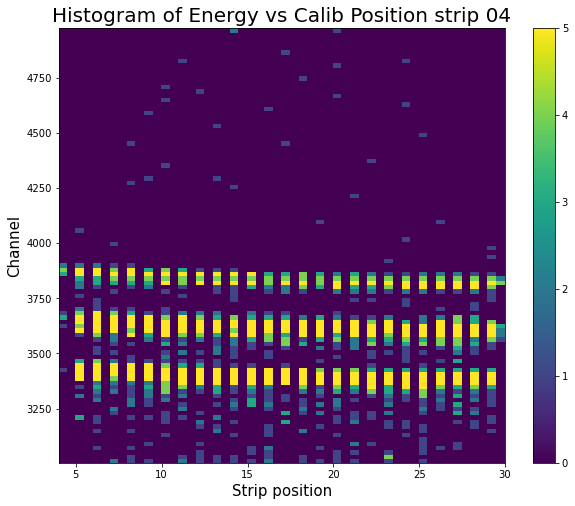

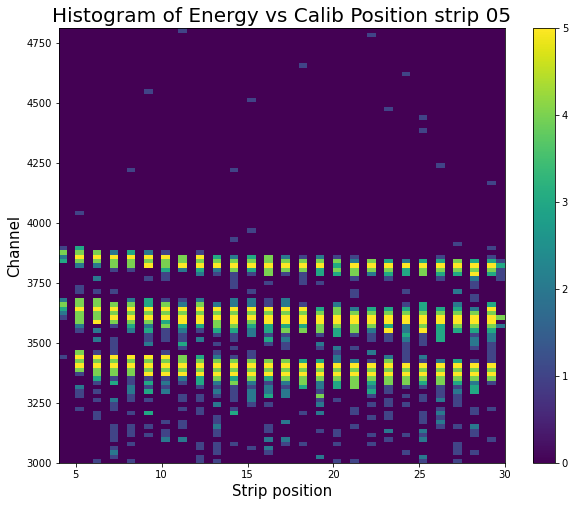

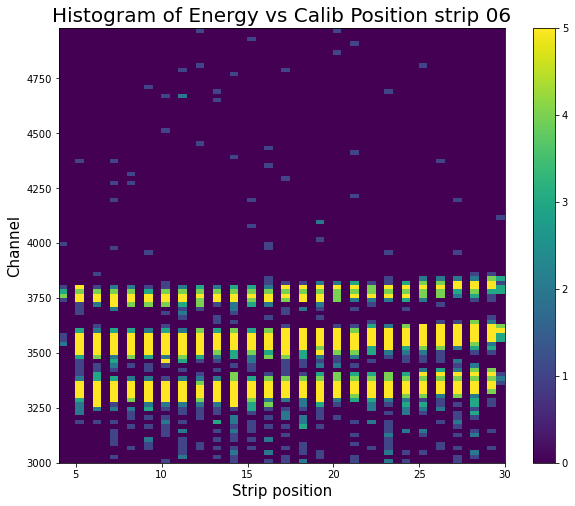

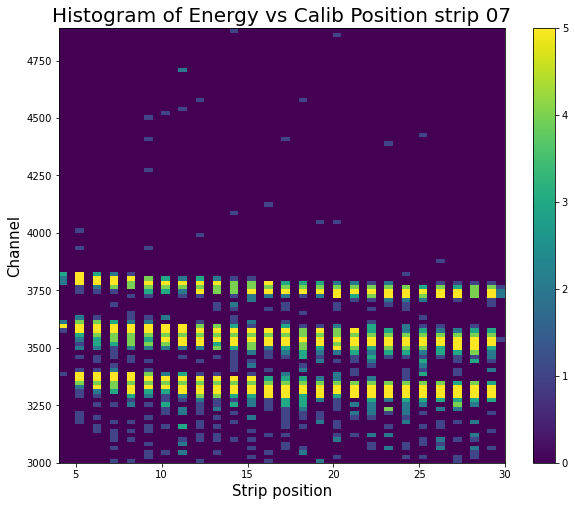

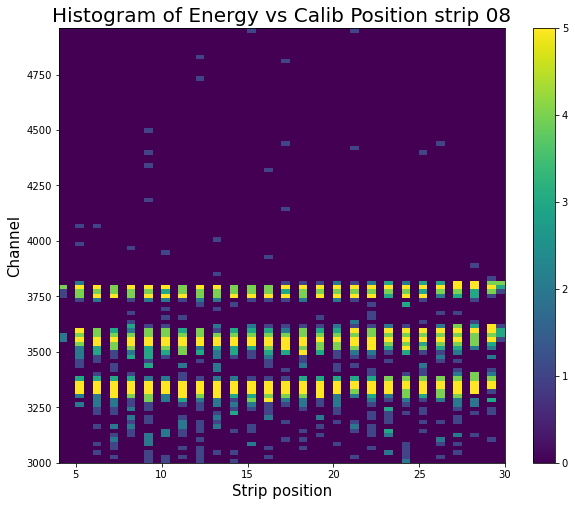

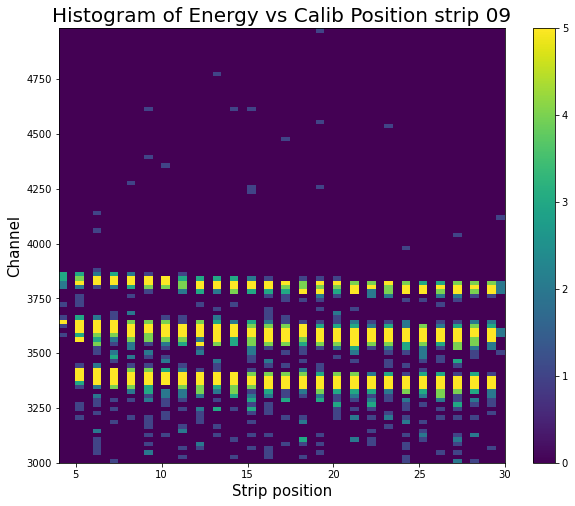

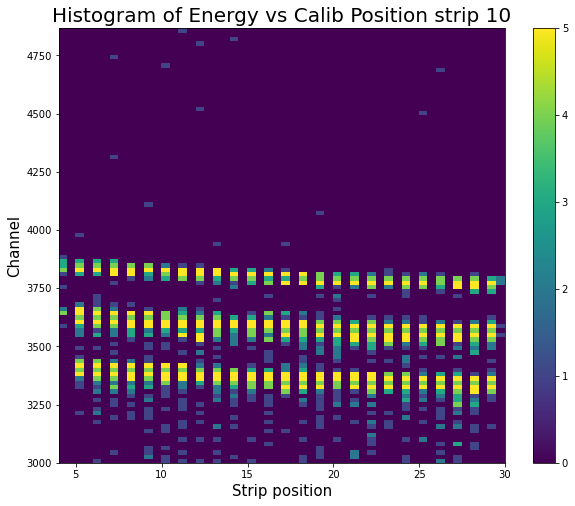

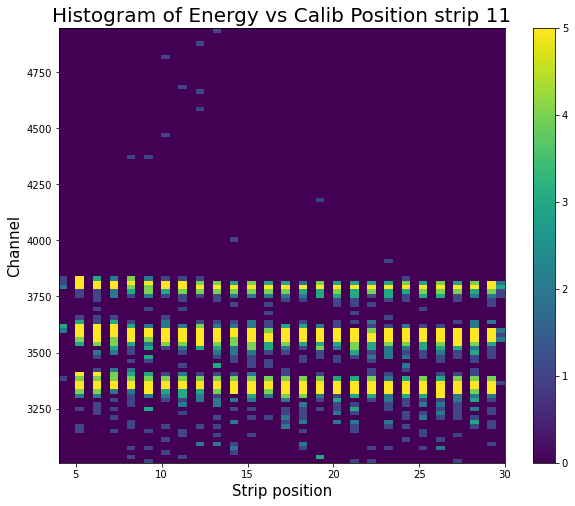

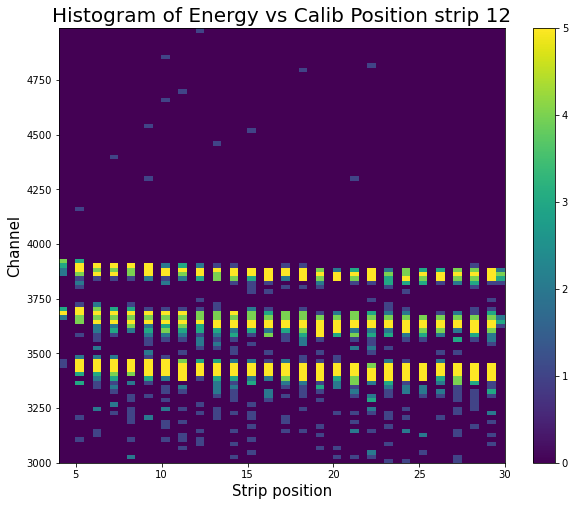

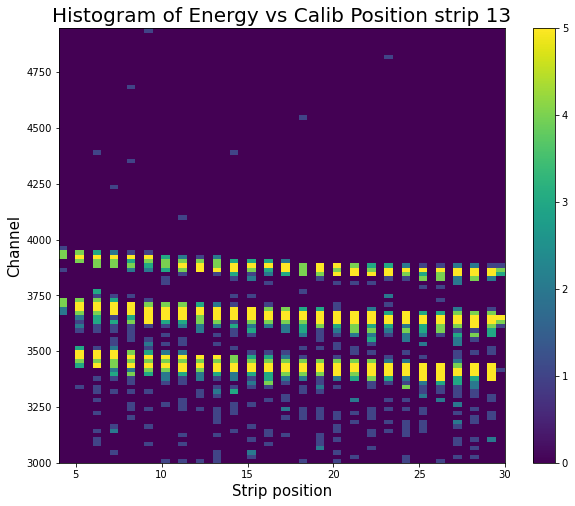

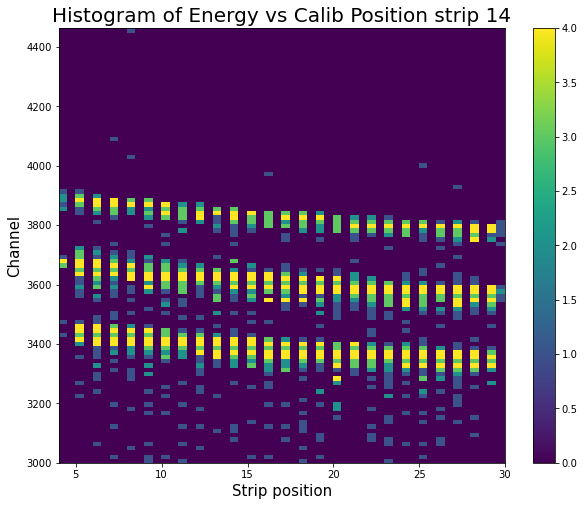

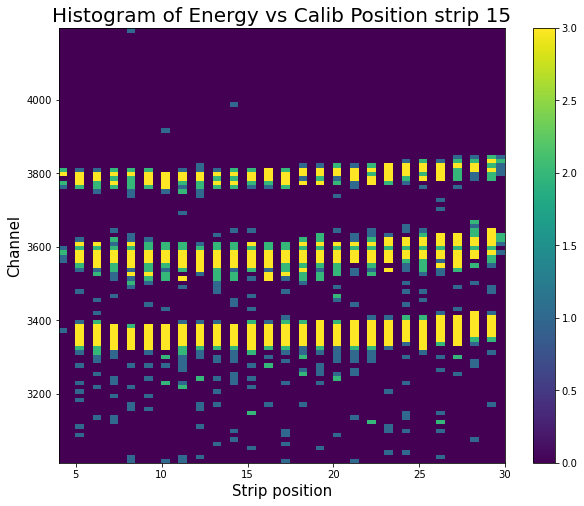

In [3]:
for ii in range(1,16):
    if ii<10:
        file = 'E vs Calib Postion top 0'+str(ii)+'.hdat'
        strip = '0'+str(ii)
    else:
        file = 'E vs Calib Postion top '+str(ii)+'.hdat'
        strip = str(ii)
    my_cal = Calib_position("# X ", "Y ")
    my_cal.read_data(file)
    my_cal.plot_hist(strip)
    #my_cal.plot_data(strip)
    #my_cal.fit_data(3500, 3700, strip) # to choose the bounds change to plot=True in the class function plot_data
    #my_cal.fit_results()
    #my_cal.write_txt('fit results', strip)
